### Cтажировка в отдел аналитики Яндекс.Афиши. 
Задача: помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- татистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Описание данных
 - Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

 - Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

 - Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### Шаг 1. Загрузить данные и подготовить их к анализу
 
Путь к файлам:
- /datasets/visits_log.csv 
- /datasets/orders_log.csv
- /datasets/costs.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st 
import seaborn as sns


In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')



In [3]:
# функция для вывода информации о датафрейме и 5 первых строк датафрейма
def show_info(df):
    display(df.head(5))
    display(df.info())
    

In [4]:
for df in [visits, orders, costs]:
    show_info(df)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

В названиях столбцов присутствуют пробелы и прописные буквы. Необходима замена названий.

In [5]:
# функция для замены пробелов в названиях столбцов на "_" и перевода к нижнему регистру
def rename_columns(df):
    df.columns = df.columns.str.replace(" ", "_").str.lower()

In [6]:
# переименуем столбцы в датафреймах visits и orders
for df in [visits, orders]:
    rename_columns(df)

In [7]:
# выведем на экран новые названия столбцов:
display(visits.columns)
display(orders.columns)


Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Нужно привести все даты в формат datetime

In [8]:
#   Функция для преобразования колонки column_name датафрейма df
def convert_to_datetime(df,column_name):    
    df = df.copy()
    df[column_name] = pd.to_datetime(df[column_name])
    return df

In [9]:
# переведем в формат даты 
visits = convert_to_datetime(visits,'end_ts')
visits = convert_to_datetime(visits,'start_ts')
orders = convert_to_datetime(orders,'buy_ts')
costs = convert_to_datetime(costs,'dt')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


#### Вывод
Данные загружены. Столбцы с датами переведены в формат  datetime64

### Шаг 2. Отчёты и основные метрики
### Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

Посчитаем количество уникальных пользователей в день/неделю/ месяц (DAU, WAU, MAU)


In [10]:
# получим колонки с датой, месяцем и неделей 
visits['date']  = visits['start_ts'].dt.date
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['week']  = visits['start_ts'].astype('datetime64[W]')
visits

,device,end_ts,source_id,start_ts,uid,date,month,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-17
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-21
...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-01,2017-07-27
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-01,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-03-01,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-11-01,2017-11-02


In [11]:
# количество уникальных пользователей в день/неделю/ месяц (DAU, WAU, MAU)
dau = visits.groupby('date').agg({'uid': 'nunique'}).reset_index()
wau = visits.groupby(['week']).agg({'uid': 'nunique'}).reset_index()
mau = visits.groupby(['month']).agg({'uid': 'nunique'}).reset_index()


In [12]:
# средние значения активности пользователей DAU, WAU, MAU
dau_total = dau.mean()
wau_total = wau.mean()
mau_total = mau.mean()
display('DAU = {}'.format(int(dau_total)))
display('WAU = {}'.format(int(wau_total)))
display('MAU = {}'.format(int(mau_total)))

'DAU = 907'

'WAU = 5724'

'MAU = 23228'

In [13]:
# количество уникальных пользователей в день/неделю/ месяц (DAU, WAU, MAU)
dau_touch = visits.query('device == "touch"').groupby('date').agg({'uid': 'nunique'}).reset_index()
wau_touch = visits.query('device == "touch"').groupby(['week']).agg({'uid': 'nunique'}).reset_index()
mau_touch = visits.query('device == "touch"').groupby(['month']).agg({'uid': 'nunique'}).reset_index()

dau_desktop = visits.query('device == "desktop"').groupby('date').agg({'uid': 'nunique'}).reset_index()
wau_desktop = visits.query('device == "desktop"').groupby(['week']).agg({'uid': 'nunique'}).reset_index()
mau_desktop = visits.query('device == "desktop"').groupby(['month']).agg({'uid': 'nunique'}).reset_index()

In [14]:
# средние значения активности пользователей DAU, WAU, MAU для touch/desktop
dau_total = dau_touch.mean()
wau_total = wau_touch.mean()
mau_total = mau_touch.mean()
display('DAU_touch = {}'.format(int(dau_total)))
display('WAU_touch = {}'.format(int(wau_total)))
display('MAU_touch = {}'.format(int(mau_total)))

dau_total = dau_desktop.mean()
wau_total = wau_desktop.mean()
mau_total = mau_desktop.mean()
display('DAU_desktop = {}'.format(int(dau_total)))
display('WAU_desktop = {}'.format(int(wau_total)))
display('MAU_desktop = {}'.format(int(mau_total)))

'DAU_touch = 252'

'WAU_touch = 1637'

'MAU_touch = 6825'

'DAU_desktop = 659'

'WAU_desktop = 4135'

'MAU_desktop = 16724'

Text(0.5, 1.0, 'График изменения MAU во времени\n')

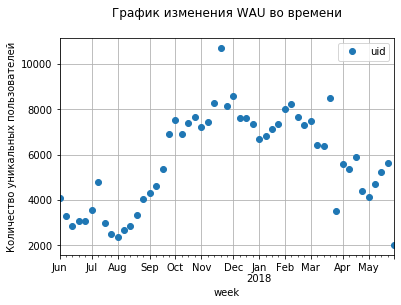

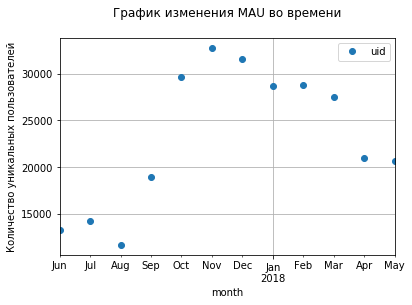

In [15]:
wau.plot(x='week', y='uid', style='o', grid=True)
plt.ylabel('Количество уникальных пользователей')
plt.title('График изменения WAU во времени' + '\n')
mau.plot(x='month', y='uid', style='o', grid=True)
plt.ylabel('Количество уникальных пользователей')
plt.title('График изменения MAU во времени'+ '\n')

Наибольшое число пользователей наблюдается с октября по март. За окном плохая погода, значит пора идти в театры и на концерты.

Text(0.5, 1.0, 'График изменения MAU для desktop во времени\n')

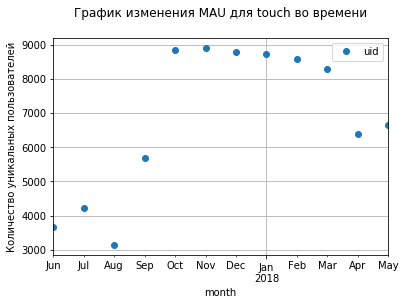

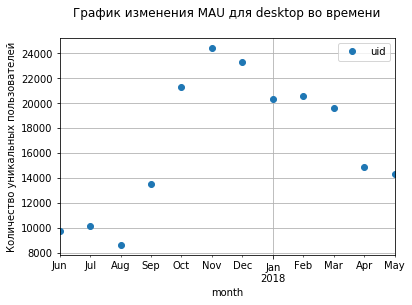

In [16]:
mau_touch.plot(x='month', y='uid', style='o', grid=True)
plt.ylabel('Количество уникальных пользователей')
plt.title('График изменения MAU для touch во времени'+ '\n')

mau_desktop.plot(x='month', y='uid', style='o', grid=True)
plt.ylabel('Количество уникальных пользователей')
plt.title('График изменения MAU для desktop во времени'+ '\n')

Наибольшое число пользователей наблюдается с октября по март. Количество уникальных пользователей в месяц существенно выше для устройств с экраном. В самые популярные месяцы для touch MAU в пределах 8-9тыс пользователей, тогда как для desktop - 20-25тыс. пользователей.

Рассчитаем, сколько сессий в день совершает пользователь

In [17]:
# количество сессий в день на одного пользователя, 
# группируем по дню и считаем количество сессий "n_sessions" и количество уникальных пользователей в день " n_users"
sessions_per_user = visits.groupby(['date']).agg(
    n_sessions=('uid', 'count'),
    n_users = ('uid', 'nunique')
) 

# делим количество сессий на количество юзеров и далее находим среднее
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)

sessions_per_user['sessions_per_user'].mean()

1.082169644003972

В среднем один пользователь в день совершает 1,08 сессий в день.

То же для touch и desctop

In [18]:
# количество сессий в день на одного пользователя для touch, 
# группируем по дню и считаем количество сессий "n_sessions" и количество уникальных пользователей в день " n_users"
sessions_per_user_touch = visits.query('device == "touch"').groupby(['date']).agg(
    n_sessions=('uid', 'count'),
    n_users = ('uid', 'nunique')
) 

# делим количество сессий на количество юзеров и далее находим среднее
sessions_per_user_touch['sessions_per_user'] = (
    sessions_per_user_touch['n_sessions'] / sessions_per_user_touch['n_users']
)

sessions_per_user_touch['sessions_per_user'].mean()

1.0510715741665035

In [19]:
# количество сессий в день на одного пользователя для touch, 
# группируем по дню и считаем количество сессий "n_sessions" и количество уникальных пользователей в день " n_users"
sessions_per_user_desktop = visits.query('device == "desktop"').groupby(['date']).agg(
    n_sessions=('uid', 'count'),
    n_users = ('uid', 'nunique')
) 

# делим количество сессий на количество юзеров и далее находим среднее
sessions_per_user_desktop['sessions_per_user'] = (
    sessions_per_user_desktop['n_sessions'] / sessions_per_user_desktop['n_users']
)

sessions_per_user_desktop['sessions_per_user'].mean()

1.0889553115247612

В среднем один пользователь в день совершает 1,08 сессий в день, для сенсорных устройств - 1,05 сессий в день, а для экранных - 1,09.

### Средняя продолжительность сессии или ASL 

In [20]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-14
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-15
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-29
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-17
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-21


Text(0.5, 0, 'Длительность сессии, сек')

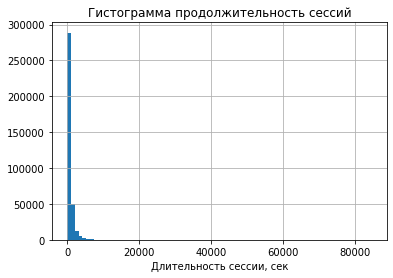

In [21]:
# вычтем из конца сессии начало, переведем все в секунды и построим гистограмму
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=80)
plt.title('Гистограмма продолжительность сессий')
plt.xlabel('Длительность сессии, сек')

Из гистограммы видно, что очень много сессий около 0 секунд. На нормальное распределение не похоже, для оценки средней длительности сессии возьмем моду.

In [22]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [23]:
# длительность сессии на touch
visits.query('device == "touch"')['session_duration_sec'].describe()

count    96833.000000
mean       479.619407
std        752.531533
min          0.000000
25%         60.000000
50%        180.000000
75%        600.000000
max      30840.000000
Name: session_duration_sec, dtype: float64

In [24]:
# длительность сессии на desktop
visits.query('device == "desktop"')['session_duration_sec'].describe()

count    262567.000000
mean        703.946977
std        1091.545596
min           0.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

In [25]:
visits['session_duration_sec'].mode()


0    60
dtype: int64

Средняя продолжительность сессии очень мала, всего 60 секунд. Возможно, пользователи просто хотели закрыть неудобную рекламу и случайно попали на сайт.

In [26]:
visits.query('device == "touch"')['session_duration_sec'].mode()

0    60
dtype: int64

In [27]:
visits.query('device == "desktop"')['session_duration_sec'].mode()

0    60
dtype: int64

Мода продолжительности сессии 60 секунд, что на  desktop, что на touch.

### Как часто люди возвращаются


In [28]:
# дата первой активности
# сгруппируем по пользователям и найдем минимальную дату захода на сайт
first_visits = visits.groupby(['uid'])['date'].min()
first_visits.name = 'first_visit_date'
first_visits



uid
11863502262781          2018-03-01
49537067089222          2018-02-06
297729379853735         2017-06-07
313578113262317         2017-09-18
325320750514679         2017-09-30
                           ...    
18446403737806311543    2017-11-30
18446424184725333426    2017-12-06
18446556406699109058    2018-01-01
18446621818809592527    2017-12-27
18446676030785672386    2017-10-04
Name: first_visit_date, Length: 228169, dtype: object

In [29]:
# добавим к датафрейму "visits" данные о первом дне посещении "first_visit_date" каждого пользователя
visits = visits.join(first_visits,on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,session_duration_sec,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,2017-12-14,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,2018-02-15,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,2017-06-29,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,2018-05-17,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,2017-12-21,0,2017-12-27


In [30]:
# первый месяц посещения, он же название когорты
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
#  lifetime когорты по месяцам
visits['cohort_lifetime'] = round((visits['month'] - visits['first_visit_month']) / np.timedelta64(1,'M')).astype('int')

# сгруппируем когорты по месяцу первого посещения, lifetime когорты и 
# посчитем количество уникальных пользователей в каждой когорте
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
# cohorts

In [31]:
# количество пользователей в каждой когорте равно числу юзеров в 0 периоде жизни когорты
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count
# добавим столбец с количеством пользователей в когорте 'cohort_users'
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts
# Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts.head()

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


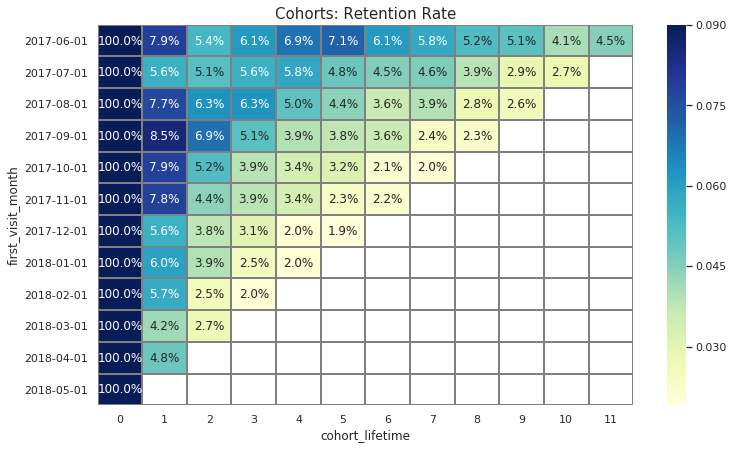

In [32]:
# Построим сводную таблицу и создадим тепловую карту
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(12, 7))
plt.title('Cohorts: Retention Rate',  fontsize = 15)
# подписи по оси у
y_axis_labels = retention_pivot.index.date
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.09,
            cmap="YlGnBu", yticklabels=y_axis_labels)



Retention Rate в первый месяц очень значительно падает (до 4%-8%) и убывает по когортам с течением времени. Исключение составляет первая когорта, где Retention Rate несколько увеличивается, начиная с третьего месяца, и даже к 12 месяцу жизни когорты все еще равен 4.5%

In [33]:
cohorts.groupby('cohort_lifetime').agg({'retention':'mean'}).head(6)


,retention
cohort_lifetime,
0,1.000000
1,0.065167
2,0.046333
3,0.042760
4,0.040595
5,0.039444


В среднем по всем когортам Retention Rate в первый месяц составляет 6.5% пользователей и уменьшается с течением времени, к 5-6 месяцу падает до 4%.


#### Посчитаем Retention Rate отдельно для устройств touch и desktop
Для этого создадим функцию для создания когорт пользователей

In [34]:


def create_cohorts(df,column_first_month, column_cohort_lifetime, column_id):
    df = df.copy()
    cohorts = df.groupby([column_first_month, column_cohort_lifetime]).agg(n_users = (column_id, 'nunique')
                                                                         ).reset_index()
    # узнаем количество покупателей в каждой когорте
    initial_users_count = cohorts[cohorts[column_cohort_lifetime] == 0][[column_first_month,'n_users']]
    initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_users'})
    # добавим количество покупателей в каждой когорте
    cohorts = cohorts.merge(initial_users_count,on=column_first_month)
    return cohorts



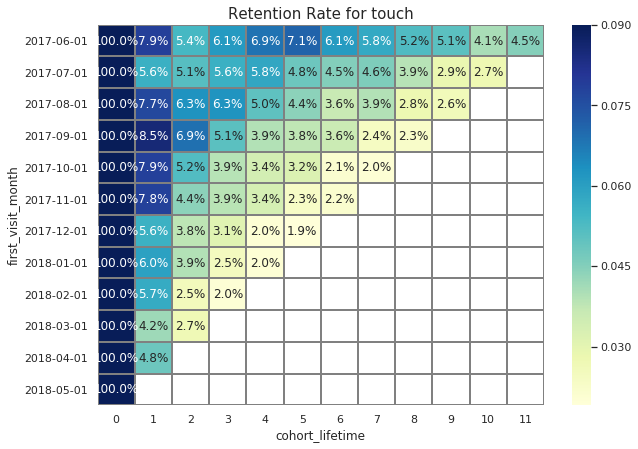

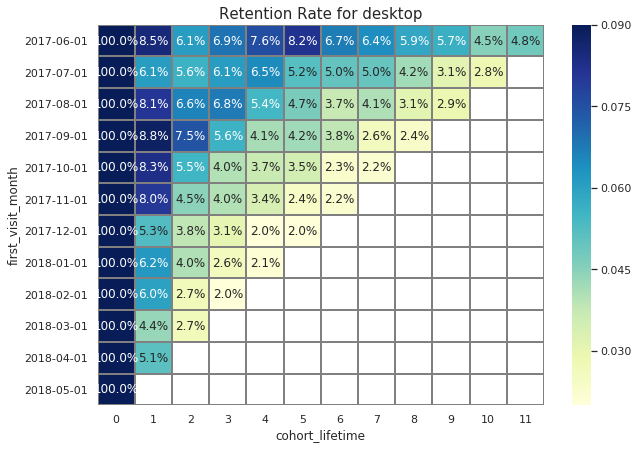

In [35]:
    
"""" Тепловая карта Retention Rate для device == "touch" """
    
# c помощью функции create_cohort получим таблицу с когортами
cohorts_touch = visits.query('device == "touch"').pipe(create_cohorts,'first_visit_month','cohort_lifetime','uid')
# cohorts_touch = visits.pipe(create_cohorts,'first_visit_month','cohort_lifetime','uid')
cohorts_touch
# Retention Rate
cohorts_touch['retention'] = cohorts_touch['n_users']/cohorts_touch['cohort_users']


# строим тепловую карту

retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(10, 7))
plt.title('Retention Rate for touch',  fontsize = 15)
# подписи по оси у
y_axis_labels = retention_pivot.index.date
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.09,
            cmap="YlGnBu", yticklabels=y_axis_labels)



"""" Тепловая карта Retention Rate для device == "desktop" """

# c помощью функции create_cohort получим таблицу с когортами
cohorts_desktop = visits.query('device == "desktop"').pipe(create_cohorts,'first_visit_month','cohort_lifetime','uid')

# Retention Rate
cohorts_desktop['retention'] = cohorts_desktop['n_users']/cohorts_desktop['cohort_users']

# строим тепловую карту 
retention_pivot = cohorts_desktop.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(10, 7))
plt.title('Retention Rate for desktop',  fontsize = 15)
# подписи по оси у
y_axis_labels = retention_pivot.index.date
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.09,
            cmap="YlGnBu", yticklabels=y_axis_labels)

In [36]:
cohorts_touch.groupby('cohort_lifetime').agg({'retention':'mean'}).head(2)

,retention
cohort_lifetime,
0,1.000000
1,0.062032


In [37]:
cohorts_desktop.groupby('cohort_lifetime').agg({'retention':'mean'}).head(2)

,retention
cohort_lifetime,
0,1.000000
1,0.068029


Retention Rate для desktop чуть выше по всем когортам, чем у touch. В среднем на 2й месяц жизни когорты для сенсорных устройств Retention Rate = 6,2%, а для устройств с экраном  Retention Rate = 6,8%


### Вывод
- Сколько людей пользуются в день, неделю, месяц?  
Средние значения активности пользователей DAU = 907, WAU = 5724, MAU = 23228.  
Для сенсорных устройств - DAU_touch = 252, WAU_touch = 1637, MAU_touch = 6825.  
Для устройств с экраном - DAU_desktop = 659, WAU_desktop = 4135, MAU_desktop = 16724.  
Наибольшое число пользователей наблюдается с октября по март. Количество уникальных пользователей в месяц существенно выше для устройств с экраном. В самые популярные месяцы для touch MAU в пределах 8-9тыс пользователей, тогда как для desktop - 20-25тыс. пользователей. 
- Сколько сессий в день?  
В среднем один пользователь в день совершает 1,08 сессий в день, для сенсорных устройств - 1,05 сессий в день, а для экранных - 1,09.
- Сколько длится одна сессия?  
Средняя продолжительность сессии очень мала, всего 60 секунд,  что на  desktop, что на touch.
- Как часто люди возвращаются?   
В среднем по всем когортам Retention Rate во второй месяц жизни когортысоставляет 6.5% пользователей и уменьшается с течением времени. Retention Rate для desktop чуть выше по всем когортам, чем у touch. В среднем на 2й месяц жизни когорты для сенсорных устройств Retention Rate = 6,2%, а для устройств с экраном  Retention Rate = 6,8%


### Отчеты и метрики по продажам
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

In [38]:
# время первого визита на сайт
first_visit_series = visits.groupby(['uid']).agg({'start_ts': 'min', 'device':'first'})
first_visit_series
# время первого заказа
first_order_series = orders.groupby('uid').agg(first_order = ('buy_ts', 'min'))
first_order_series
# объединим две серии в одну таблицу по id пользователя, и вычтем время первой сессии из времени первой покупки 
visits_turn_order = first_order_series.merge(first_visit_series, on='uid')
visits_turn_order['time_before_buy'] = (visits_turn_order['first_order'] - visits_turn_order['start_ts'])
visits_turn_order.describe()

,time_before_buy
count,36523
mean,16 days 21:40:10.550064
std,47 days 01:44:46.481416
min,0 days 00:00:00
25%,0 days 00:04:00
50%,0 days 00:16:00
75%,2 days 00:17:00
max,363 days 07:04:00


In [39]:
visits_turn_order.query('device == "desktop"').describe()

,time_before_buy
count,29222
mean,16 days 08:09:31.240161
std,46 days 16:19:52.306353
min,0 days 00:00:00
25%,0 days 00:04:00
50%,0 days 00:15:00
75%,1 days 07:10:00
max,363 days 07:04:00


In [40]:
visits_turn_order.query('device == "touch"').describe()

,time_before_buy
count,7301
mean,19 days 03:44:47.705793
std,48 days 13:10:49.281514
min,0 days 00:00:00
25%,0 days 00:04:00
50%,0 days 00:27:00
75%,5 days 17:40:00
max,362 days 16:47:00


Более 50% пользователей делают заказ уже через 16 минут после того, как зашли на сайт. Лишь четверть пользователей покупает билеты спустя более 2 дней после того, как первый раз зашли на сайт. Очевидно, люди четко знают, за какими билетами они пришли на сайт. Для сенсорных устройств медианное время, через которое совершается покупка чуть выше - 27 минут

#### Сколько раз покупают за период?

In [41]:
first_order_series
orders = orders.join(first_order_series,on='uid')
orders = orders.merge(visits_turn_order[['device']], on = 'uid')

In [42]:
orders

,buy_ts,revenue,uid,first_order,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,desktop
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,desktop
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,desktop
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,desktop
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,desktop


In [43]:
# добавим месяц первой покупки
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')


#  lifetime когорты по месяцам
orders['cohort_lifetime'] = round((orders['buy_month'] - orders['first_order_month']) / np.timedelta64(1,'M')).astype('int')


cohorts = orders.groupby(['first_order_month','cohort_lifetime']).agg(
    n_orders=('uid', 'count'),
    n_users = ('uid', 'nunique')
).reset_index()


cohorts.head(10)
# cohorts.groupby('first_order_month').agg(cohort_orders = ('n_orders', 'sum'))

,first_order_month,cohort_lifetime,n_orders,n_users
0,2017-06-01,0,2354,2023
1,2017-06-01,1,177,61
2,2017-06-01,2,174,50
3,2017-06-01,3,226,54
4,2017-06-01,4,292,88
5,2017-06-01,5,218,67
6,2017-06-01,6,276,62
7,2017-06-01,7,174,47
8,2017-06-01,8,212,58
9,2017-06-01,9,153,45


In [44]:
# узнаем количество покупателей в каждой когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_order_month','n_users']]
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_customer'})
initial_users_count

cohorts = cohorts.merge(initial_users_count,on='first_order_month')


# cohorts = cohorts.drop(['cohort_customer_x', 'cohort_customer_y'], axis=1)
cohorts.head(5)

,first_order_month,cohort_lifetime,n_orders,n_users,cohort_customer
0,2017-06-01,0,2354,2023,2023
1,2017-06-01,1,177,61,2023
2,2017-06-01,2,174,50,2023
3,2017-06-01,3,226,54,2023
4,2017-06-01,4,292,88,2023


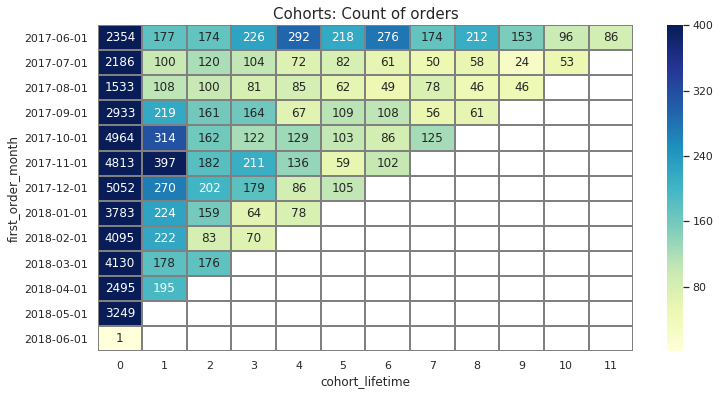

In [45]:
# количество заказов в каждой когорте
orders_pivot = cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='n_orders',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('Cohorts: Count of orders',  fontsize = 15)
# подписи по оси у
y_axis_labels = orders_pivot.index.date
sns.heatmap(orders_pivot, annot=True, linewidths=1, linecolor='gray', vmax = 400, fmt='.0f',
            cmap="YlGnBu", yticklabels=y_axis_labels)

У нас есть функция для создания когорт, в которой мы считали количество уникальных ID и количество пользователей в когорты, добавим в эту функцию возможность подсчитать количество заказов, назовем ее "def create_cohorts_orders"

In [46]:

def create_cohorts_orders(df,column_first_month, column_cohort_lifetime, column_id):
    df = df.copy()
    cohorts = df.groupby([column_first_month, column_cohort_lifetime]).agg(n_users = (column_id, 'nunique'),
                                                                           n_orders=('uid', 'count')
                                                                          ).reset_index()
    # узнаем количество покупателей в каждой когорте
    initial_users_count = cohorts[cohorts[column_cohort_lifetime] == 0][[column_first_month,'n_users']]
    initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_users'})
    # добавим количество покупателей в каждой когорте
    cohorts = cohorts.merge(initial_users_count,on=column_first_month)
    return cohorts

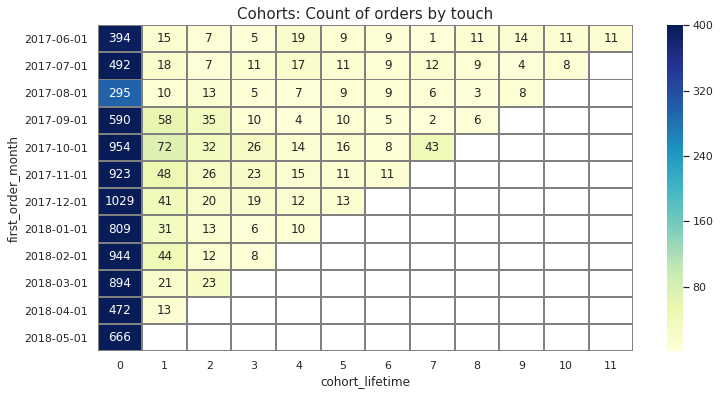

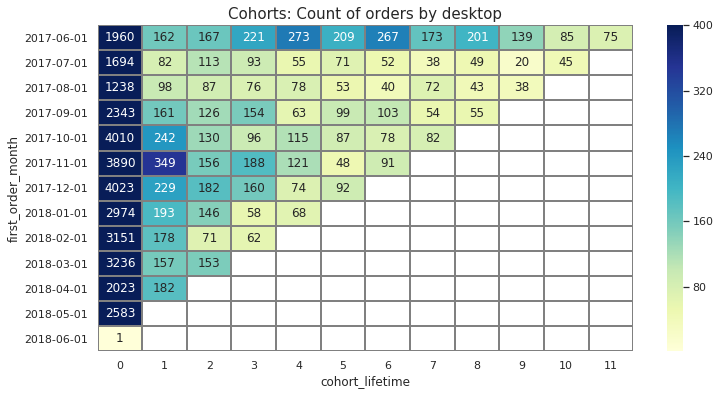

In [47]:
# количество заказов в каждой когорте для touch 
cohorts_touch = orders.query('device == "touch"').pipe(create_cohorts_orders, 'first_order_month','cohort_lifetime','uid')

# количество заказов в каждой когорте для desktop 
cohorts_desktop = orders.query('device == "desktop"').pipe(create_cohorts_orders, 'first_order_month','cohort_lifetime','uid')
cohorts_touch


#  построим тепловую карту для touch
orders_pivot1 = cohorts_touch.pivot_table(index='first_order_month',columns='cohort_lifetime',values='n_orders',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('Cohorts: Count of orders by touch',  fontsize = 15)
# подписи по оси у
y_axis_labels = orders_pivot1.index.date
sns.heatmap(orders_pivot1, annot=True, linewidths=1, linecolor='gray', vmax = 400, fmt='.0f',
            cmap="YlGnBu", yticklabels=y_axis_labels)

#  построим тепловую карту для desktop
orders_pivot2 = cohorts_desktop.pivot_table(index='first_order_month',columns='cohort_lifetime',values='n_orders',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(12, 6))
plt.title('Cohorts: Count of orders by desktop',  fontsize = 15)
# подписи по оси у
y_axis_labels = orders_pivot2.index.date
sns.heatmap(orders_pivot2, annot=True, linewidths=1, linecolor='gray', vmax = 400, fmt='.0f',
            cmap="YlGnBu", yticklabels=y_axis_labels)

In [48]:
# среднее количество заказов в 0периоде жизни для touch
orders_pivot1.mean()[0]

705.1666666666666

In [49]:
# среднее количество заказов в 0периоде жизни для desktop
orders_pivot2.mean()[0]

2548.153846153846

С сенсорных устройств заказов в разы меньше меньше,чем с тех, у которых большой экран. В среднем 705 заказов в первый месяц жизни когорт для сенсорных устройств против 2548 для экранных. Это логично, на маленьком экране, к примеру, трудно выбрать места в зале

Билеты на концерты, в театр покупают не каждый месяц, значит нужно взять период в несколько месяцев. Возьмем данные за период в 6 месяцев, у нас есть 7 когорт, с данными по 6 месяцам (2017-06-01 до 2017-12-01)

In [51]:
# оставим в датафрейме только когорты до 2017-12 и только с cohort_lifetime 0 - 5, 
# затем сгруппируем по когортам и посчитаем суммарное количество заказов 
# и возьмем количество покупателей из нулевой жизни когорты
orders_per_user = cohorts.query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")\
                         .groupby('first_order_month')\
                         .agg(cohort_orders = ('n_orders', 'sum'),
                              cohort_customer = ('n_users','first')
                                 )
orders_per_user['orders_per_user'] = orders_per_user['cohort_orders'] / orders_per_user['cohort_customer']
orders_per_user

,cohort_orders,cohort_customer,orders_per_user
first_order_month,,,
2017-06-01,3441,2023,1.700939
2017-07-01,2664,1923,1.385335
2017-08-01,1969,1370,1.437226
2017-09-01,3653,2581,1.415343
2017-10-01,5794,4340,1.335023
2017-11-01,5798,4081,1.420730
2017-12-01,5894,4383,1.344741


Сколько в среднем делают заказы за 6 месяцев с desktopa

In [52]:
orders_per_user_desktop = cohorts_desktop.query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")\
                         .groupby('first_order_month')\
                         .agg(cohort_orders = ('n_orders', 'sum'),
                              cohort_customer = ('n_users','first')
                                 )
orders_per_user_desktop['orders_per_user'] = orders_per_user_desktop['cohort_orders'] / orders_per_user_desktop['cohort_customer']
orders_per_user_desktop

,cohort_orders,cohort_customer,orders_per_user
first_order_month,,,
2017-06-01,2992,1676,1.785203
2017-07-01,2108,1508,1.397878
2017-08-01,1630,1113,1.464510
2017-09-01,2946,2061,1.429403
2017-10-01,4680,3519,1.329923
2017-11-01,4752,3328,1.427885
2017-12-01,4760,3503,1.358835


In [53]:
orders_per_user_touch = cohorts_touch.query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")\
                         .groupby('first_order_month')\
                         .agg(cohort_orders = ('n_orders', 'sum'),
                              cohort_customer = ('n_users','first')
                                 )
orders_per_user_touch['orders_per_user'] = orders_per_user_touch['cohort_orders'] / orders_per_user_touch['cohort_customer']
orders_per_user_touch

,cohort_orders,cohort_customer,orders_per_user
first_order_month,,,
2017-06-01,449,347,1.293948
2017-07-01,556,415,1.339759
2017-08-01,339,257,1.319066
2017-09-01,707,520,1.359615
2017-10-01,1114,821,1.356882
2017-11-01,1046,753,1.389110
2017-12-01,1134,880,1.288636


За 6 месяцев в среднем в первой когорте один пользователь сделал 1,7 заказов. В следующих когортах этот показатель в пределах (1,3 - 1,4) заказов за 6 месяцев. При заказе с экранного устройства этот показатель чуть выше примерно на 0,01-0,1 пункта в каждой когорте. При заказе с сенсорных устройств количество заказов одного пользователя ниже, причем особенно низкий в первой когорте, всего 1,29 заказа за 6 месяцев

- Какой средний чек?

In [54]:
# сгруппируем заказы по месяцам и вычислим средний чек за месяц
revenue_mean = orders.groupby('buy_month').agg({'revenue':'mean'}).reset_index()
revenue_by_device = orders.pivot_table(index='buy_month',columns = 'device', values='revenue').reset_index()

revenue_by_device = revenue_mean.merge(revenue_by_device, on='buy_month')
revenue_by_device.sort_values(by = 'revenue', ascending = False)

,buy_month,revenue,desktop,touch
6,2017-12-01,5.852139,6.422581,3.327461
3,2017-09-01,5.416448,5.694357,4.156324
9,2018-03-01,5.413930,5.556024,4.824821
1,2017-07-01,5.306589,5.295824,5.345996
10,2018-04-01,5.150645,5.249970,4.671512
4,2017-10-01,4.928280,4.980811,4.698038
2,2017-08-01,4.847139,4.894062,4.629094
8,2018-02-01,4.840095,5.192534,3.459544
5,2017-11-01,4.783518,4.660333,5.317361
11,2018-05-01,4.771279,4.910394,4.173085


Топ-3 самых высоких значений среднего чека - в декабре, сентябре и марте(5.85, 5.42, 5.41 руб). Для экранных устройств в топе те же месяцы, только значения среднего чека выше(6.42, 5.69, 5,56руб) Для сенсорных устройств, напротив в декабре и сентябре  самый низкий средний чек, а высокий - в июле(5,35 руб) и в ноябре(5,32руб).  

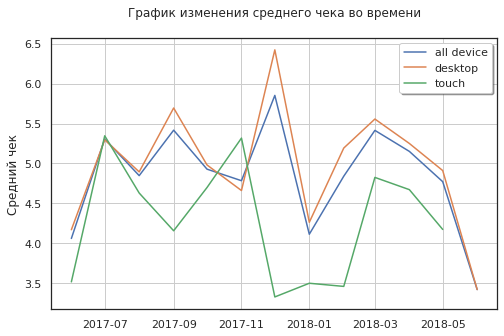

In [55]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 5))
plt.ylabel('Средний чек')
plt.title('График изменения среднего чека во времени'+ '\n')

ax1.plot(revenue_by_device['buy_month'],revenue_by_device['revenue'])
ax1.plot(revenue_by_device['buy_month'],revenue_by_device['desktop'])
ax1.plot(revenue_by_device['buy_month'],revenue_by_device['touch'])
ax1.grid()
ax1.legend(['all device','desktop','touch'],loc='best', ncol=1, shadow=True);

Средний чек через desktop чуть выше,чем в среднем для заказов.  Средний чек через touch почти всегда ниже, особенно это заметно для сентября и декабря 2017. Возможно, это какие-то групповые заказы на школьников/детей для школьной программы/Нового года, а большие заказы удобнее делать через desktop.

#### Добавим источники перехода на сайт
Далее мы будем считать LTV, CAC, ROMI и нам интересно насколько выгодны разные источники рекламы, поэтому добавим в датафрейм orders  данные  по источнику перехода (source_id)

In [56]:
# visits_turn_order содержит информацию по уникальным пользователям которые соверщали покупку,
# для каждого уникального пользователя , совершавшего покупку есть поле "start_ts" ( из "visits") его первого визита на сайт,
# по нему можно привязать данные из визитов по источнику перехода
unique_id_by_source =  visits_turn_order.merge(visits, on= ['uid','start_ts'])[['uid','source_id','month' ]]
unique_id_by_source
orders = orders.merge(unique_id_by_source, on='uid' )
orders

,buy_ts,revenue,uid,first_order,device,buy_month,first_order_month,cohort_lifetime,source_id,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,desktop,2017-06-01,2017-06-01,0,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,desktop,2017-06-01,2017-06-01,0,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,desktop,2017-06-01,2017-06-01,0,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,desktop,2017-06-01,2017-06-01,0,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,desktop,2017-06-01,2017-06-01,0,3,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,desktop,2018-05-01,2018-05-01,0,4,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,desktop,2018-05-01,2018-05-01,0,10,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,desktop,2018-05-01,2018-05-01,0,3,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,desktop,2018-05-01,2018-05-01,0,3,2017-10-01


#### Сколько денег приносят покупатели? (LTV)

В проекте нет данных по margin_rate , будем считать margin_rate = 100% и валовая прибыль равна revenue

In [57]:
# когорты по суммарному доходу 
revenue_by_cohort = orders.groupby(['first_order_month','source_id','buy_month']).agg({'revenue':'sum',
                                                                           'uid':'nunique', 
                                                                           'cohort_lifetime':'first'                                                                        
                                                                          })
revenue_by_cohort.head(15)

revenue  uid  cohort_lifetime
first_order_month source_id buy_month                                
2017-06-01        1         2017-06-01  1378.70  190                0
                            2017-07-01   414.98   16                1
                            2017-08-01   419.43   10                2
                            2017-09-01   714.24    9                3
                            2017-10-01   811.20   12                4
                            2017-11-01   389.34   15                5
                            2017-12-01   490.48    9                6
                            2018-01-01   479.23   11                7
                            2018-02-01   432.15    8                8
                            2018-03-01   316.30    7                9
                            2018-04-01   228.92   11               10
                            2018-05-01   317.42   10               11
                  2         2017-06-01  1043.68  235                0
                            2017-07-01   115.54    8                1
                            2017-08-01    63.90    8                2

In [58]:
# добавим количество пользователей в каждой когорте
cohort_sizes = revenue_by_cohort.groupby(['first_order_month','source_id']).agg(n_uid = ('uid','first'))
revenue_by_cohort = revenue_by_cohort.merge(cohort_sizes, on=['first_order_month','source_id']).reset_index()

In [59]:
revenue_by_cohort['ltv'] = revenue_by_cohort['revenue'] / revenue_by_cohort['n_uid']
revenue_by_cohort.head(10)
# revenue_by_cohort[revenue_by_cohort['source_id'] == 10]

,first_order_month,source_id,revenue,uid,cohort_lifetime,n_uid,ltv
0,2017-06-01,1,1378.70,190,0,190,7.256316
1,2017-06-01,1,414.98,16,1,190,2.184105
2,2017-06-01,1,419.43,10,2,190,2.207526
3,2017-06-01,1,714.24,9,3,190,3.759158
4,2017-06-01,1,811.20,12,4,190,4.269474
5,2017-06-01,1,389.34,15,5,190,2.049158
6,2017-06-01,1,490.48,9,6,190,2.581474
7,2017-06-01,1,479.23,11,7,190,2.522263
8,2017-06-01,1,432.15,8,8,190,2.274474
9,2017-06-01,1,316.30,7,9,190,1.664737


Посчитаем LTV за 6 месяцев. Это можно сделать для 7 когорт с 2017-06-01 по 2017-12-01

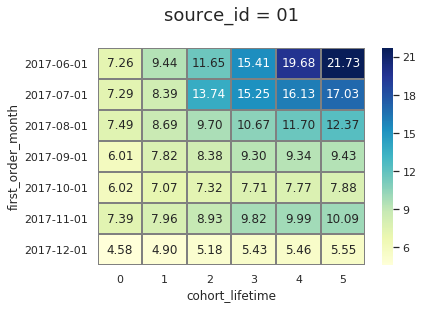

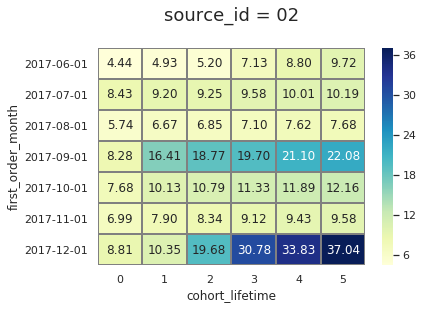

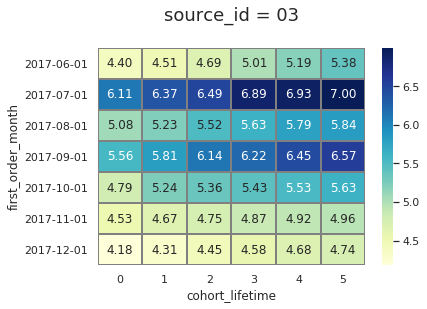

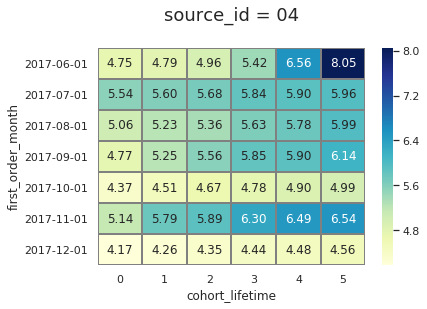

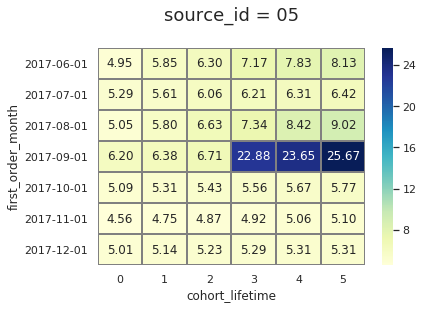

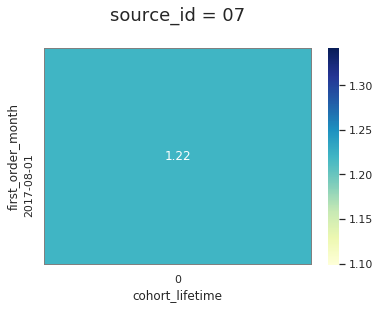

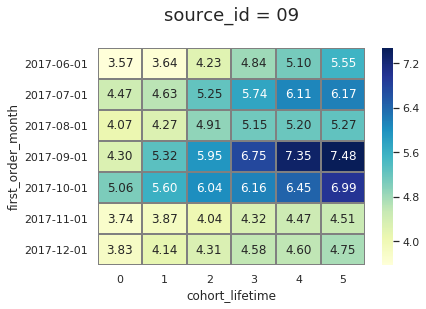

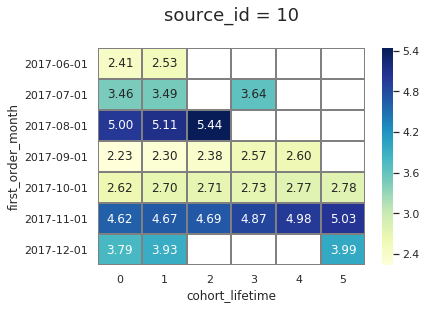

In [60]:

# Кумулятивный LTV сгруппированный по источникам


for key, data in revenue_by_cohort.groupby(['source_id']): 
    ltv_pivot = (
    data
    .query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")    
    .pivot_table(index=['first_order_month'],columns='cohort_lifetime',values='ltv',aggfunc='mean'))
#     print('source =',key)
#     print(ltv_pivot)
    
    plt.figure(figsize=(6, 4))
    plt.title("source_id = {0:02d}".format(key) + '\n', fontsize = 18)
# подписи по оси у
    y_axis_labels = ltv_pivot.index.date
    sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, linewidths=1, linecolor='gray', fmt='0.2f',
            cmap="YlGnBu", yticklabels=y_axis_labels)
#     sns.heatmap(ltv_pivot, annot=True, linewidths=1, linecolor='gray', fmt='0.2f',
#             cmap="YlGnBu", yticklabels=y_axis_labels)
    


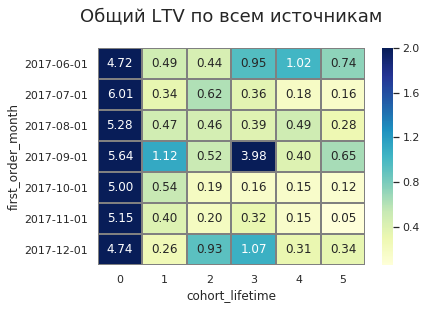

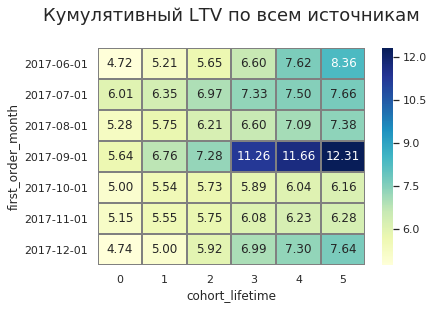

In [61]:
revenue_by_cohort_all = orders.groupby(['first_order_month','buy_month']).agg({'revenue':'sum',
                                                                           'uid':'nunique', 
                                                                           'cohort_lifetime':'first'})
cohort_sizes = (
    revenue_by_cohort_all.
    groupby(['first_order_month']).agg(n_uid = ('uid','first'))
)

revenue_by_cohort_all = revenue_by_cohort_all.merge(
    cohort_sizes, on=['first_order_month']).reset_index()

revenue_by_cohort_all['ltv'] = revenue_by_cohort_all['revenue'] / revenue_by_cohort_all['n_uid']


ltv_pivot = (
    revenue_by_cohort_all
    .query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")    
    .pivot_table(index=['first_order_month'],columns='cohort_lifetime',values='ltv',aggfunc='sum'))

    
plt.figure(figsize=(6, 4))
plt.title("Общий LTV по всем источникам" + '\n', fontsize = 18)
# подписи по оси у
y_axis_labels = ltv_pivot.index.date
# sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, linewidths=1, linecolor='gray', fmt='0.2f',
#             cmap="YlGnBu", yticklabels=y_axis_labels);
sns.heatmap(ltv_pivot, annot=True, linewidths=1, linecolor='gray', fmt='0.2f', vmax = 2,
            cmap="YlGnBu", yticklabels=y_axis_labels);

plt.figure(figsize=(6, 4))
plt.title("Кумулятивный LTV по всем источникам" + '\n', fontsize = 18)
# подписи по оси у
y_axis_labels = ltv_pivot.index.date
sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, linewidths=1, linecolor='gray', fmt='0.2f',
            cmap="YlGnBu", yticklabels=y_axis_labels);
# sns.heatmap(ltv_pivot, annot=True, linewidths=1, linecolor='gray', fmt='0.2f', vmax = 2,
#             cmap="YlGnBu", yticklabels=y_axis_labels);

In [62]:
# средний LTV за 6 месяцев по когортам
ltv_pivot.sum(axis=1).mean()

7.969052630207336

### Вывод. Продажи.
- Сколько денег приносят? (LTV)  

Средний LTV по всем когортам составляет 7,97 руб/6 месяцев. Выше среднего LTV - сентябрьская и июньская когорта.  
По общему LTV выделяется сентябрьская когорта, за 6 месяцев суммарный LTV составил 12,31 руб. Это на 50% больше, чем во второй по прибыльности июньской когорте (LTV = 8.36 руб/6 мес). Причем, серьезный прирост LTV для сентябрьской когорты наблюдается в декабре, на 3 месяц жизни когорты - 3,98 руб/мес, это 70% от LTV для 0 месяца декабрьской когорты (LTV 0 = 5.64 руб/мес).  
затем идуи июльская, августовская и декабрьская когорты с результатами LTV за 6 месяцев: 7,38 -7,66 руб/6 мес.    
Худшие результаты у октябрьской и ноябрьской LTV за 6 месяцев: 6,16 - 6,28 руб/6 мес.  
За 6 месяцев источник 1 принес хорошую прибыль для июньской и июльской когорты( LTV = 21,73 руб/6 мес и 17,03руб/6 мес), в следующие когорты LTV источника №1 падает.   
Источник №2 показывает высокий LTV для сентябрьской(LTV =22,08 руб/6 мес) и для декабрьской когорты (LTV =37,04 руб/6 мес).  
По источникам №№ 3,4,9 LTV всех когорт низок (4,7 - 8,0 руб/6 мес.).  
По источнику №5  LTV всех когорт низок (5,1 - 9,0 руб/6 мес.), за исключением сентябрьской (LTV =25,67 руб/6 мес).  
По источнику №10 LTV очень низок, в самых удачных когортах LTV лишь 5,03(в ноябрьской) и 5,44 (в августовской). Причем, в пяти когортах, покупатели привлеченные по источнику №10 не возвращались снова за новыми заказами




- Когда люди начинают покупать?  

Более 50% пользователей делают заказ уже через 16 минут после того, как зашли на сайт. Лишь четверть пользователей покупает билеты спустя более 2 дней после того, как первый раз зашли на сайт. Для экранных устройств время почти такое же, ведь большинство заказов поступает через экранные устройства. Для сенсорных устройств медианное время, через которое совершается покупка чуть выше - 27 минут

- Сколько раз покупают за период? 

С сенсорных устройств заказов в разы меньше,чем с тех, у которых большой экран. В среднем 705 заказов в первый месяц жизни когорт для сенсорных устройств против 2548 для экранных.
За 6 месяцев в среднем в первой когорте один пользователь сделал 1,7 заказов. В следующих когортах этот показатель в пределах (1,3 - 1,4) заказов за 6 месяцев. При заказе с экранного устройства этот показатель чуть выше примерно на 0,01-0,1 пункта в каждой когорте. При заказе с сенсорных устройств количество заказов одного пользователя ниже, причем особенно низкий в первой когорте, всего 1,29 заказа за 6 месяцев

- Какой средний чек?

Топ-3 самых высоких значений среднего чека - в декабре, сентябре и марте(5.85, 5.42, 5.41 руб). Для экранных устройств в топе те же месяцы, только значения среднего чека выше(6.42, 5.69, 5,56руб) Для сенсорных устройств, напротив в декабре и сентябре самый низкий средний чек, а высокий - в июле(5,35 руб) и в ноябре(5,32руб).  

### Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)  



In [63]:
# затраты на рекламу по месяцам
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_by_month_all = costs.groupby(['month']).agg({'costs':'sum'}).reset_index()
costs_by_month_all.sort_values(by ='costs', ascending =False )


,month,costs
6,2017-12-01,38315.35
5,2017-11-01,37907.88
4,2017-10-01,36322.88
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27
3,2017-09-01,24368.91
10,2018-04-01,22289.38
11,2018-05-01,22224.27
1,2017-07-01,18240.59


In [64]:
#  затраты на рекламу по разным источникам
costs.groupby('source_id').agg({'costs':'sum'}).sort_values(by ='costs', ascending =False )


,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


Самые большие затраты на рекламу для источника №3 -141 тыс.руб, самые меньшие траты на источники №№ 1 (20,8 тыс. руб ), №9(5,5 тыс.руб), №10 (5,8 тыс.руб)

In [65]:
costs_by_month = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()
costs_by_month

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


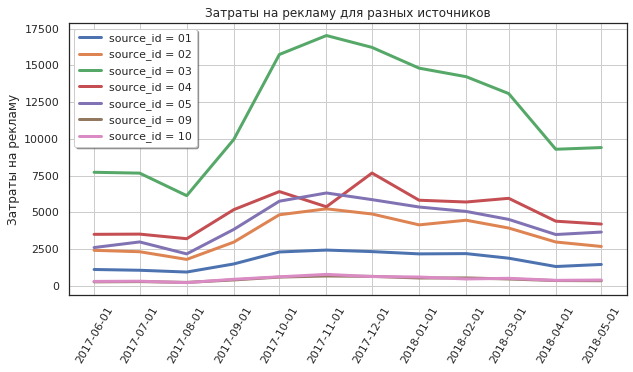

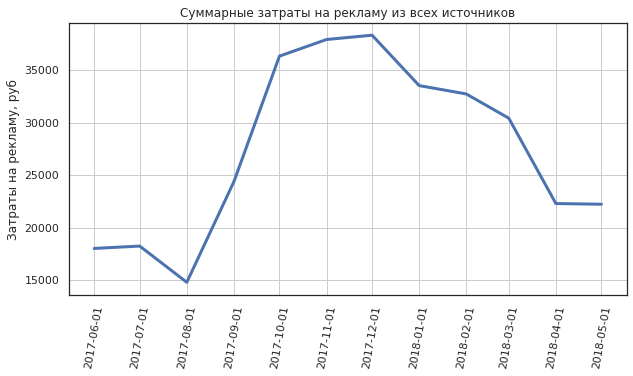

In [66]:


fig, ax1 = plt.subplots(nrows = 1, ncols = 1)
for key, data in costs_by_month.groupby(['source_id']): 
    ax1.plot(data['month'], data['costs'], label = "source_id = {0:02d}".format(key), linewidth = 3)    
    ax1.set_xticks(data['month'])

ax1.set_ylabel('Затраты на рекламу')
ax1.set_title('Затраты на рекламу для разных источников')
ax1.grid()

# plt.xticks( rotation='vertical')
ax1.tick_params(axis='x', labelrotation=60) 

ax1.legend(loc='best', ncol=1, shadow=True)   

fig.set_figwidth(10)
fig.set_figheight(5)


fig, ax2 = plt.subplots(nrows = 1, ncols = 1)

ax2.plot(costs.groupby('month').agg({'costs':'sum'}), label = "all", linewidth = 3)
ax2.grid()
ax2.set_xticks(data['month'])
ax2.tick_params(axis='x', labelrotation=80) 
ax2.set_title('Суммарные затраты на рекламу из всех источников')
plt.ylabel('Затраты на рекламу, руб')
fig.set_figwidth(10)
fig.set_figheight(5)

plt.show()

Самые большие траты на рекламу в декабре - октябре, самые низкие - летом, с июня по август. Источник №3 самый затратный на протяжении всего года, затраты на источники №№ 9 и 10  самые низкие и даже в осенне-зимний период их не увеличивают. 

### Сколько стоило привлечение одного покупателя из каждого источника?

In [67]:
# visits_turn_order содержит информацию по уникальным пользователям которые соверщали покупку,
# для каждого уникального пользователя , совершавшего покупку есть поле "start_ts" ( из "visits") его первого визита на сайт,
# по нему можно привязать данные из визитов по источнику перехода
visits_turn_order.head()

,first_order,start_ts,device,time_before_buy
uid,,,,
313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,desktop,106 days 23:02:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,touch,0 days 00:00:00
2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,desktop,0 days 01:19:00
2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,desktop,0 days 19:44:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,desktop,0 days 00:00:00


In [68]:
customer_per_month_by_source = \
    unique_id_by_source.groupby(['source_id', 'month']).agg(n_customer = ('uid', 'count')).reset_index()
customer_per_month_by_source


,source_id,month,n_customer
0,1,2017-06-01,240
1,1,2017-07-01,184
2,1,2017-08-01,126
3,1,2017-09-01,248
4,1,2017-10-01,350
...,...,...,...
80,10,2018-01-01,103
81,10,2018-02-01,113
82,10,2018-03-01,166
83,10,2018-04-01,98


In [69]:
# revenue_by_cohort

In [70]:
# Считаем САС
# затраты на рекламу в месяц для каждого источника
costs_by_month = costs.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()

# соединим c  таблиц revenue_by_cohort , где есть количество  покупателей по когортам
cac_by_source = costs_by_month.merge(revenue_by_cohort, left_on = ['source_id', 'month'], 
                                                    right_on = ['source_id', 'first_order_month'])
#  разделим  маркетинговые затраты  на количество покупателей
cac_by_source['cac'] = \
    cac_by_source['costs'] / cac_by_source['n_uid']


cac_by_source

,source_id,month,costs,first_order_month,revenue,uid,cohort_lifetime,n_uid,ltv,cac
0,1,2017-06-01,1125.61,2017-06-01,1378.70,190,0,190,7.256316,5.924263
1,1,2017-06-01,1125.61,2017-06-01,414.98,16,1,190,2.184105,5.924263
2,1,2017-06-01,1125.61,2017-06-01,419.43,10,2,190,2.207526,5.924263
3,1,2017-06-01,1125.61,2017-06-01,714.24,9,3,190,3.759158,5.924263
4,1,2017-06-01,1125.61,2017-06-01,811.20,12,4,190,4.269474,5.924263
...,...,...,...,...,...,...,...,...,...,...
509,10,2018-03-01,526.41,2018-03-01,638.44,186,0,186,3.432473,2.830161
510,10,2018-03-01,526.41,2018-03-01,12.71,5,1,186,0.068333,2.830161
511,10,2018-03-01,526.41,2018-03-01,6.29,3,2,186,0.033817,2.830161
512,10,2018-04-01,388.25,2018-04-01,261.93,107,0,107,2.447944,3.628505


In [71]:
# CAC ДЛЯ ВСЕХ источников

# затраты на рекламу в месяц
costs_by_month = costs.groupby(['month']).agg({'costs':'sum'}).reset_index()

# соединим c  таблицей revenue_by_cohort , где есть количество  покупателей по когортам
cac_per_month = costs_by_month.merge(revenue_by_cohort_all, left_on = [ 'month'], 
                                                    right_on = [ 'first_order_month'])
#  разделим  маркетинговые затраты  на количество покупателей
cac_per_month['cac'] = \
    cac_per_month['costs'] / cac_per_month['n_uid']
cac_per_month.head()


,month,costs,first_order_month,revenue,uid,cohort_lifetime,n_uid,ltv,cac
0,2017-06-01,18015.0,2017-06-01,9557.49,2023,0,2023,4.724414,8.905091
1,2017-06-01,18015.0,2017-06-01,981.82,61,1,2023,0.485329,8.905091
2,2017-06-01,18015.0,2017-06-01,885.34,50,2,2023,0.437637,8.905091
3,2017-06-01,18015.0,2017-06-01,1931.30,54,3,2023,0.954671,8.905091
4,2017-06-01,18015.0,2017-06-01,2068.58,88,4,2023,1.022531,8.905091


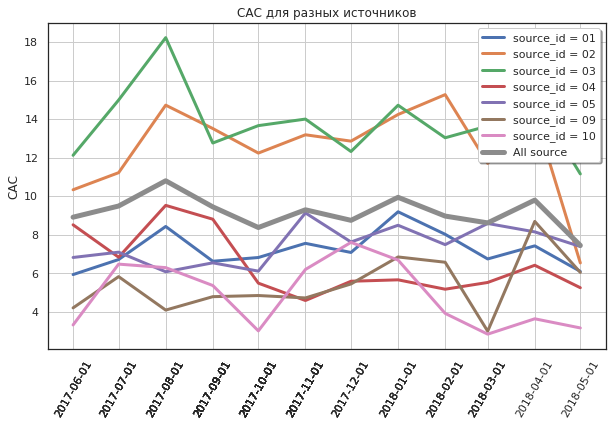

In [72]:
# рассчитаем САС во времени
fig, ax1 = plt.subplots(nrows = 1, ncols = 1)
for key, data in cac_by_source.groupby(['source_id']): 
    ax1.plot(data['month'], data['cac'], label = "source_id = {0:02d}".format(key), linewidth = 3)    
    ax1.set_xticks(data['month'])
# CAC по всем источникам
ax1.plot(cac_per_month['month'], cac_per_month['cac'], label = "All source", linewidth = 5)

ax1.set_ylabel('CAC')
ax1.set_title('CAC для разных источников')
ax1.grid()

ax1.tick_params(axis='x', labelrotation=60) 
ax1.legend(loc='best', ncol=1, shadow=True)   
# ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1, shadow=True) 
fig.set_figwidth(10)
fig.set_figheight(6)

# ax1.plot(customer_per_month['month'], customer_per_month['cac'], label = "dct", linewidth = 3)
# customer_per_month.plot(x='month', y='cac', label = " ", linewidth = 2, grid=True)
plt.show()

In [73]:
# посчитаем средний САС
cac_by_source['cac'].mean()

8.50215567312589

In [74]:
# посчитаем средний САС по источникам
cac_by_source.groupby(['source_id']).agg({'cac':'mean'})

,cac
source_id,
1,7.147620
2,12.639600
3,14.056894
4,6.980528
5,7.171887
9,5.059117
10,5.039289


Источники поделились на 2 группы: для источников 2 и 3 стоимость привлечения клиента выше среднего CAC = 8.5 руб, для источников 1,4,5,9,10 стоимость привлечения клиента ниже среднего CAC

### На сколько окупились расходы? (ROI)

Чтобы посчитать общий ROMI разделим LTV на CAC 

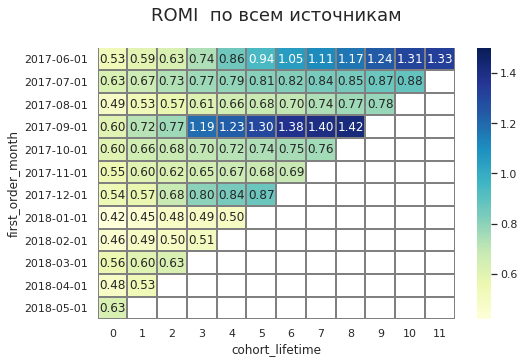

In [75]:

cac_per_month['romi'] = cac_per_month['ltv'] / cac_per_month['cac']
output = cac_per_month.pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)
plt.figure(figsize=(8, 5))
plt.title('ROMI  по всем источникам' + '\n', fontsize = 18)

# подписи по оси у
y_axis_labels = output.index.date
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray', vmax = 1.5,  fmt='0.2f',
            cmap="YlGnBu", yticklabels=y_axis_labels );

Окупились только июньская и сентябрьская когорта. Июньская на 7 месяц жизни, сентябрьская на 4 месяц. Остальные когорты очень далеки до окупаемости, ROMI к 6 месяцу жизни составляет (68% - 87%).


Рассмотрим окупаемость затрат по источникам. Возьмем период в 6 месяцев. По каждому источнику найдем LTV за 6 месяцев, поделим на затраты в соответствующий месяц и получим в результате накопительный ROMI за период в 6 месяцев. Сведем в одну таблицу, где по оси х будут источники, а значения у - это результирующий ROMI  за 6 месяцев 

In [76]:
# найдем суммарный ltv за 6 месяцев
# ltv_group_by_source = revenue_by_cohort.query("first_order_month <= '2017-12-01'")\
ltv_group_by_source = revenue_by_cohort.query("first_order_month <= '2017-12-01' and cohort_lifetime <= 5 ")\
    .groupby(['source_id','first_order_month']).agg(ltv_6month = ('ltv','sum'))

# ROMI для LTV за 6 месяцев
romi_by_source = (
    cac_by_source
    .merge(ltv_group_by_source, left_on = ['source_id','month'], right_on = ['source_id','first_order_month'])
)

romi_by_source['romi'] = (romi_by_source['ltv_6month']) / romi_by_source['cac']
romi_by_source.head(5)

,source_id,month,costs,first_order_month,revenue,uid,cohort_lifetime,n_uid,ltv,cac,ltv_6month,romi
0,1,2017-06-01,1125.61,2017-06-01,1378.70,190,0,190,7.256316,5.924263,21.725737,3.667247
1,1,2017-06-01,1125.61,2017-06-01,414.98,16,1,190,2.184105,5.924263,21.725737,3.667247
2,1,2017-06-01,1125.61,2017-06-01,419.43,10,2,190,2.207526,5.924263,21.725737,3.667247
3,1,2017-06-01,1125.61,2017-06-01,714.24,9,3,190,3.759158,5.924263,21.725737,3.667247
4,1,2017-06-01,1125.61,2017-06-01,811.20,12,4,190,4.269474,5.924263,21.725737,3.667247


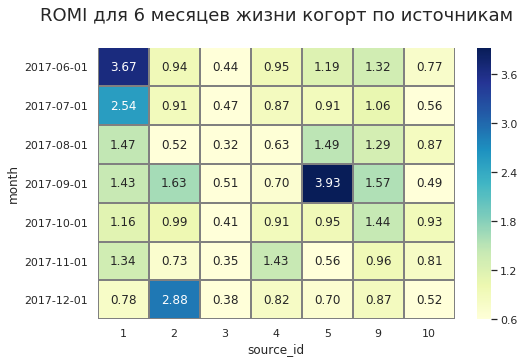

In [77]:
#  выведем таблицу, где по оси х будут разные источники,
# а значения у - это результирующий ROMI для LTV за 6 месяцев
output = romi_by_source.pivot_table(
        index='month', 
        columns='source_id', 
        values='romi', 
        aggfunc='mean')

output.round(2)
plt.figure(figsize=(8, 5))
plt.title('ROMI для 6 месяцев жизни когорт по источникам' + '\n', fontsize = 18)

# подписи по оси у
y_axis_labels = output.index.date
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray', vmin=0.6, fmt='0.2f',
            cmap="YlGnBu", yticklabels=y_axis_labels );


Источник №3 не окупился за 6 месяцев ни для одной когорты, источник №10 также показывает плохие результаты. Декабрьская когорта убыточна по всем источникам, кроме источника №2.
Если не брать в расчет декабрьскую когорту, стабильно высокий ROMI показывают источник № 1.

In [78]:
# средний ROMI по когортам для каждого источника
output.mean()

source_id
1     1.768576
2     1.229496
3     0.413851
4     0.900297
5     1.387731
9     1.216218
10    0.705912
dtype: float64

### Вывод. Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени

Самые большие траты на рекламу в декабре, ноябре, октябре (38.3 , 37.9, 36,3 тыс.руб соответственно). Наименьшие траты на маркетинг июле, июне, августе (18.2, 18.0, 14,8 тыс руб. соответственно)
Самые большие затраты на рекламу для источника №3 -141 тыс.руб, самые меньшие траты на источники №№ 1 (20,8 тыс. руб ), №9(5,5 тыс.руб), №10 (5,8 тыс.руб)
Источник №3 самый затратный на протяжении всего года, затраты на источники №№ 9 и 10  самые низкие и даже в осенне-зимний период их не увеличивают.  

- Сколько стоило привлечение одного покупателя из каждого источника?

Средний САС по всем источникам =8.5 руб. 
Источники поделились на 2 группы: для источников №2 (12.64 руб/чел) и №3 (14.06 руб/чел) стоимость привлечения клиента выше среднего CAC  , для источников 1,4,5,9,10 стоимость привлечения клиента ниже среднего CAC - от 5,04 руб/чел(№10) до 7,17 руб/чел(№5)

- На сколько окупились расходы? (ROI) 

Окупились только июньская и сентябрьская когорта. Июньская на 6 месяц жизни, сентябрьская на 4 месяц. Остальные когорты очень далеки до окупаемости, ROMI к 6 месяцу жизни составляет (68% - 87%)  
Источник №3 не окупился за 6 месяцев ни для одной когорты, источник №10 также показывает плохие результаты. Декабрьская когорта убыточна по всем источникам, кроме источника №2.
Если не брать в расчет декабрьскую когорту, стабильно высокий ROMI показывают источник № 1.
К 6 месяцу жизни когорты затраты на маркетинг окупились для источников №№ 1, 2, 5, 9. Для источника №3 затраты окупились лишь на 41%, для источника №10 - на 71%

### Общий вывод и рекомендации по маркетингу:

1. Окупаемость затрат(ROMI)

Окупились только июньская и сентябрьская когорта. Июньская на 7 месяц жизни, сентябрьская на 4 месяц. К концу наблюдений ROMI июньской когорты = 133%, ROMI сентябрьской когорты = 142%. Остальные когорты очень далеки до окупаемости, ROMI к 6 месяцу жизни составляет (68% - 87%).

1. Из сводной таблицы расчета ROMI для LTV = 6 месяцев : 

Лучше всего окупились затраты на маркетинг у источников №№ 1, 2, 5,9. Причем для источника 1 в июне-июле 2017 года быда особо удачная рекламная компания, которая окупилась на 360%. Для источника 5, была удачная сентябрьская компания, также окупилась на 390%. Стоит посмотреть отдельно, что это было за кампании, возможно повторить.  
Для декабрьской когорты все рекламные компании оказались убыточными, за исключением источника 2, возможно в декабре стоит снизить маркетинговые траты на все источники, за исключением источнка 2.  
Затраты на источники 3 и 10 окупились лишь на 50 и 78%% соответственно, стоит снизить маркетинговые затраты на эти источники.

2. Заказов с устройств desktop гораздо больше чем с устройств touch

В среднем 705 заказов в первый месяц жизни когорт для сенсорных устройств против 2548 для экранных. Пользователей на desktop также больше: для сенсорных устройств MAU_touch = 6825, для устройств с экраном -  MAU_desktop = 16724. Средний чек с устройств desktop также выше, причем он имеет три ярко выраженных пика - в сентябре, декабре и марте. Для сенсорных устройств в сентябре и декабре - минимальный средний чек за год. В сентябре, декабре и марте стоит сосредоточится на рекламе для экранных устройств. 

3. Общий LTV 

Средний LTV по всем когортам составляет 7,97 руб/6 месяцев.
Следует обратить внимание именно на сентябрьскую когорту, за 6 месяцев суммарный LTV составил 12,31 руб. Это на 50% больше, чем во второй по прибыльности июньской когорте (LTV = 8.36 руб/6 мес). Причем, серьезный прирост LTV для сентябрьской когорты наблюдается в декабре, на 3 месяц жизни когорты - 3,98 руб/мес, это 70% от LTV для 0 месяца декабрьской когорты (LTV 0 = 5.64 руб/мес).  

4. LTV по источникам перехода на сайт

Наиболее удачный источник рекламы  - это источник №2, он показывает высокий LTV для сентябрьской(LTV =22,08 руб/6 мес) и для декабрьской когорты (LTV =37,04 руб/6 мес). При этом САС выше среднего (12.64 руб/чел) А собственно в сентябре и декабре самый высокий средний чек заказа.  
Источник 1 имеет очень высокий средний ROMI = 1.77. Он принес очень хорошую прибыль для июньской и июльской когорты 2017 года (LTV = 21,73 руб/6 мес и 17,03руб/6 мес), но в следующие когорты LTV источника №1 падает. Возможно для будущех вложений этот источник уже не будет так хорош.  
Источник 5 имеет хороший средний ROMI = 1.39. Причем LTV всех когорт низок (5,1 - 9,0 руб/6 мес.), за исключением сентябрьской (LTV =25,67 руб/6 мес). Возможно для источника №5 стоит сосредоточить внимание именно на маркетинговые акции в сентябре, в остальные месяцы уменьшить затраты.





